In [9]:
from citrination_client import CitrinationClient
from citrination_client import PifSystemReturningQuery
from citrination_client import DatasetQuery
from citrination_client import DataQuery
from citrination_client import Filter

from pypif.pif import dumps
import json 
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import yaml
from sklearn import preprocessing
from sklearn import linear_model
import sklearn
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeavePGroupsOut

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.neighbors.kde import KernelDensity

In [10]:
#client = CitrinationClient(site='my_site',api_key='my_key' ) 

In [11]:
with open("citrination_api_key_ssrl.txt", "r") as g: 
    api_key = g.readline()

a_key = api_key.strip()

client = CitrinationClient(site='https://slac.citrination.com',api_key=a_key ) 

In [22]:
list_of_datasets = [1,15,16]

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

In [35]:
# updated function for new Citrination API
# return dataframe with features and labels 
def get_data_from_Citrination(client, dataset_id_list):
    df = pd.DataFrame(columns= [['experiment_id', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std', 'bad_data', 'form', 'precursor', 'structure', 
                                 'ro_shpere', 'sigma_sphere', 'g_precursor', 'rg_precursor']])
    for dataset in dataset_id_list:
        query = PifSystemReturningQuery(
            from_index=0,
            size=100,
            query=DataQuery(
                dataset=DatasetQuery(
                    id=Filter(
                    equal=dataset))))


        all_hits = []
        while len(all_hits) < 1200: # max for one dataset
            current_result = client.search(query)
            if current_result.hits is None:
                break
            all_hits.extend(current_result.hits)
            query.from_index += len(current_result.hits)
        
        for line in all_hits: # every line of pifs is one sample; we need to extract labels and features from it
            try:
                my_str = dumps(line)
                obj = json.loads(my_str) # to transform the string to dictionary
                
                # default values for labels
                bad_data = False
                form = False
                precursor = False
                structure = False
                
                ro_sphere = None
                sigma_sphere = None
                g_precursor = None
                rg_precursor = None
                
                experiment_id = None
                
                for i in obj['system']['ids']:
                    if i['name'] == 'EXPERIMENT_ID':
                        experiment_id = i['value']
                    
                for pr in obj['system']['properties']:

                    # extract features                    
                    if pr['name'] == 'q_Imax':
                        q_Imax = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'Imax_over_Imean':
                        Imax_over_Imean = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'Imax_sharpness':
                        Imax_sharpness = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'logI_fluctuation':
                        logI_fluctuation = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'logI_max_over_std':
                        logI_max_over_std = np.float32(pr['scalars'][0]['value'])

                    # extract labels
                    if pr['name'] == 'bad_data':
                        bad_data = True
                        continue
                    if pr['name'] == 'form_factor_scattering':
                        form = True
                    if pr['name'] == 'diffraction_peaks':
                        structure = True
                    if pr['name'] == 'precursor scattering':
                        precursor = True
                        
                    if pr['name'] == 'r0_sphere':
                        ro_sphere = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'sigma_sphere':
                        sigma_sphere = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'G_precursor':
                        g_precursor = np.float32(pr['scalars'][0]['value'])
                    if pr['name'] == 'rg_precursor':
                        rg_precursor = np.float32(pr['scalars'][0]['value'])

                df.loc[df.shape[0]] = [experiment_id, q_Imax, Imax_over_Imean, Imax_sharpness, logI_fluctuation, 
                                           logI_max_over_std, bad_data, form, precursor, structure,
                                      ro_sphere, sigma_sphere, g_precursor, rg_precursor]
            except:
                # May be in PAWS we need to put a custom exeption here
                my_str = dumps(line)
                obj = json.loads(my_str) # to transform the string to dictionary
                print(obj)
                continue
                                 
    return df.convert_objects(convert_numeric=True)

In [36]:
d = get_data_from_Citrination(client, list_of_datasets)

In [37]:
d.head()

,experiment_id,q_Imax,Imax_over_Imean,Imax_sharpness,logI_fluctuation,logI_max_over_std,bad_data,form,precursor,structure,ro_shpere,sigma_sphere,g_precursor,rg_precursor
0,R1,0.488538,1.312717,1.271242,7.916098,6.268310,True,False,False,False,NaN,NaN,NaN,NaN
1,R1,0.275225,1.234932,1.132456,9.904497,5.549794,True,False,False,False,NaN,NaN,NaN,NaN
2,R1,0.357429,1.275898,1.166689,5.827428,3.660412,True,False,False,False,NaN,NaN,NaN,NaN
3,R1,0.336618,1.240092,1.143083,7.461594,4.006636,True,False,False,False,NaN,NaN,NaN,NaN
4,R1,0.227360,1.254006,1.229550,6.997641,5.272323,True,False,False,False,NaN,NaN,NaN,NaN


In [38]:
d.shape

(1946, 14)

In [39]:
shuffled_rows = np.random.permutation(d.index)
data = d.loc[shuffled_rows]

**Steps to get a good linear regression model**
(by https://machinelearningmastery.com/linear-regression-for-machine-learning/)
1. Linear Assumption. Linear regression assumes that the relationship between your input and output is linear. You may need to transform data to make the relationship linear (e.g. log transform for an exponential relationship).
2. Remove Noise. Linear regression assumes that your input and output variables are not noisy. Consider using data cleaning operations that let you better expose and clarify the signal in your data. This is most important for the output variable and you want to remove outliers in the output variable (y) if possible.
3. Remove Collinearity. Linear regression will over-fit your data when you have highly correlated input variables. Consider calculating pairwise correlations for your input data and removing the most correlated.
4. Gaussian Distributions. Linear regression will make more reliable predictions if your input and output variables have a Gaussian distribution. You may get some benefit using transforms (e.g. log or BoxCox) on you variables to make their distribution more Gaussian looking.
5. Rescale Inputs: Linear regression will often make more reliable predictions if you rescale input variables using standardization or normalization.

## Distribution of values for all features

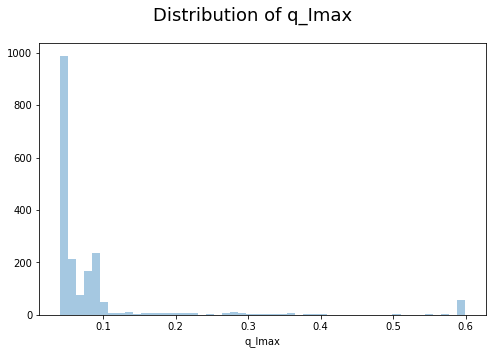

In [40]:
plt.figure(figsize=(8,5))
sns.distplot(data['q_Imax'], kde=False, bins=50)
plt.suptitle("Distribution of q_Imax ", fontsize=18)

We have a lot of q_max value about 0.04. It is not an error. Often our scatters are decreasing functions of intensivity from q. Thus, we often have max value of I for the smalles angel (q). 

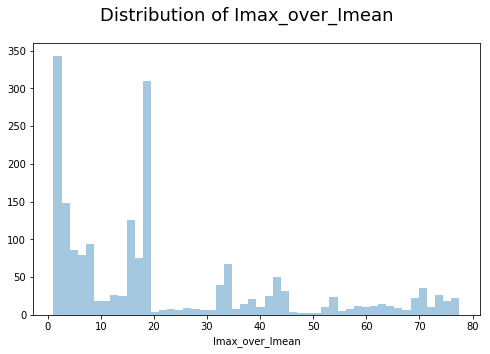

In [41]:
plt.figure(figsize=(8,5))
sns.distplot(data['Imax_over_Imean'], kde=False, bins=50)
plt.suptitle("Distribution of Imax_over_Imean ", fontsize=18)

In [622]:
data['Imax_over_Imean'].mean()

21.77651394118018

In [623]:
data['Imax_over_Imean'].std()

21.325991240622958

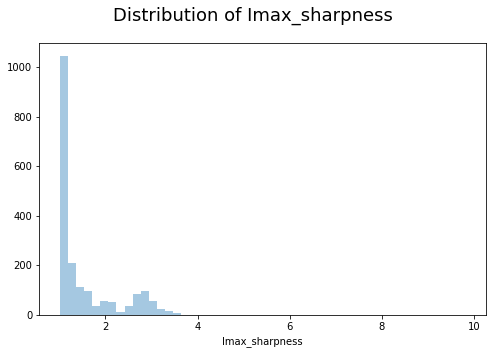

In [624]:
plt.figure(figsize=(8,5))
sns.distplot(data['Imax_sharpness'], kde=False, bins=50)
plt.suptitle("Distribution of Imax_sharpness ", fontsize=18)

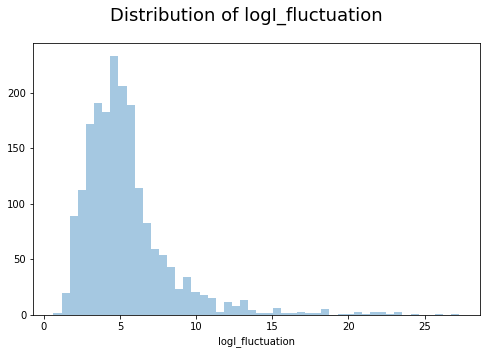

In [625]:
plt.figure(figsize=(8,5))
sns.distplot(data['logI_fluctuation'], kde=False, bins=50)
plt.suptitle("Distribution of logI_fluctuation ", fontsize=18)

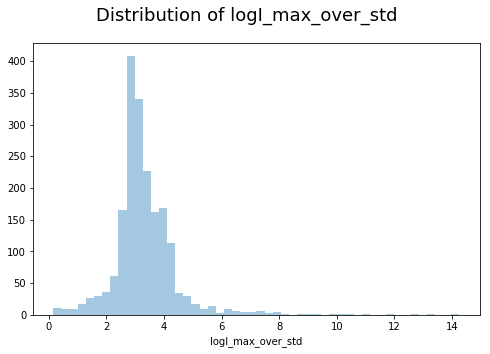

In [626]:
plt.figure(figsize=(8,5))
sns.distplot(data['logI_max_over_std'], kde=False, bins=50)
plt.suptitle("Distribution of logI_max_over_std ", fontsize=18)

### Outliers stratagee

1. Exclude outliers for labels
2. At training / testing time exclude outliers from training and validation sets, but not exclude them from testing set.

In [24]:
# we need to save the version of sklearn to use in PAWS
current_version = list(map(int,sklearn.__version__.split('.')))
major,minor,patch = current_version
current_version

[0, 19, 0]

In [25]:
# I am saving version of sklearn with all scalers and models. 
# Then I will dump them into a yaml file that will be used in PAWS app.
scalers = {} 
models = {}
scalers_and_models = {'version':current_version, 'scalers' : scalers, 'models': models}

## Spherical scatterer - size distribution paramentrs
### ro_sphere (mean radius)

In [873]:
# I will use only data with form= True and struture = False
data_sphere = data[(data['form']== True) & (data['structure']==False)]
data_sphere.shape

(726, 14)

In [738]:
data_sphere.experiment_id.value_counts()

R1            240
R12           117
R5             79
R13            77
Reaction_C     54
Reaction_D     42
Reaction_H     38
Reaction_E     36
Reaction_G      7
R4              6
Reaction_A      6
R2              5
Reaction_B      5
R6              5
R7              5
R3              4
Name: experiment_id, dtype: int64

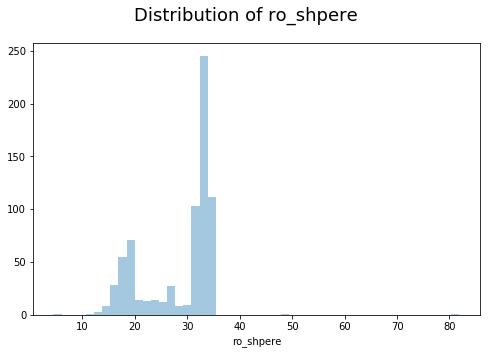

In [707]:
plt.figure(figsize=(8,5))
sns.distplot(data_sphere['ro_shpere'], kde=False, bins=50)
plt.suptitle("Distribution of ro_shpere ", fontsize=18)

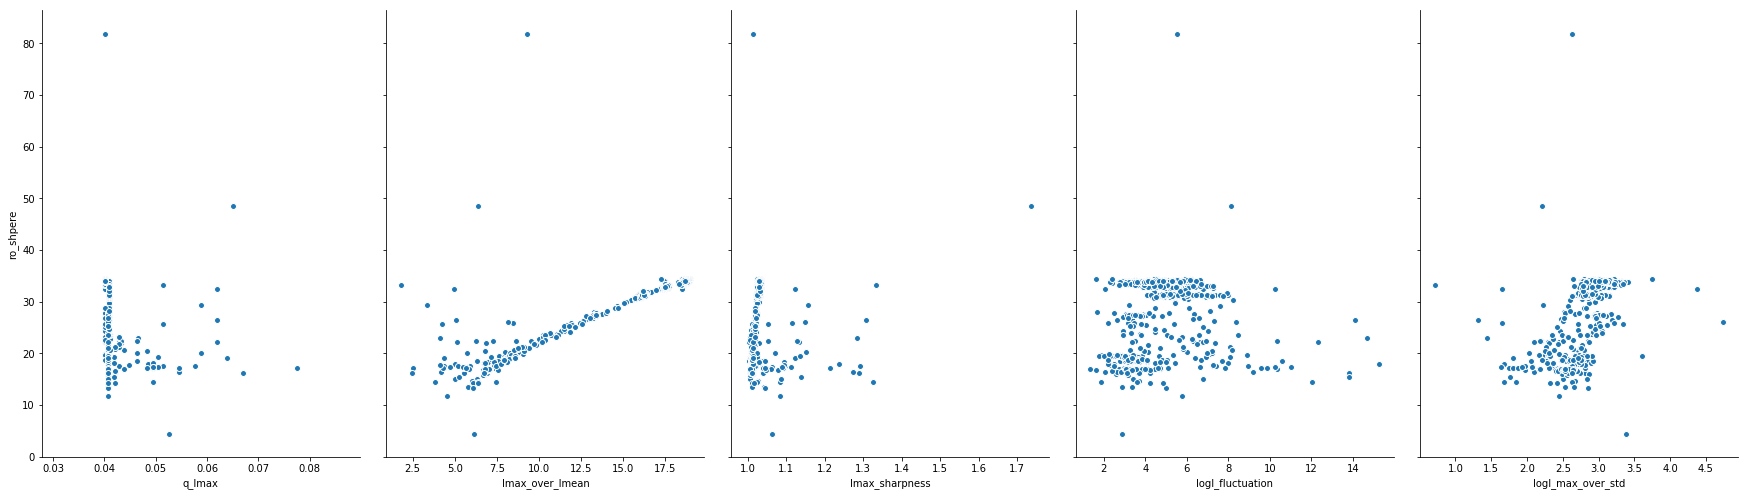

In [708]:
sns.pairplot(data_sphere, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='ro_shpere', size=7, aspect=0.7)

This visualization shows that:
1. We have only two features that are correlated with 'ro_shpere'
2. We have some outliers.

Thus, I am going to use only 'Imax_over_Imean' and 'logI_max_over_std' for training.

In [874]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

scaler = preprocessing.StandardScaler()
scaler.fit(data_sphere[features])
data_sphere[features] = scaler.transform(data_sphere[features])
data_sphere.head()

,experiment_id,q_Imax,Imax_over_Imean,Imax_sharpness,logI_fluctuation,logI_max_over_std,bad_data,form,precursor,structure,ro_shpere,sigma_sphere,g_precursor,rg_precursor
1825,Reaction_E,-0.096732,-1.349484,-0.527659,-0.862615,-0.297477,False,True,False,False,18.296806,0.131609,NaN,NaN
78,R1,-0.329793,0.884754,0.007260,0.170916,0.455891,False,True,False,False,33.983646,0.036602,NaN,NaN
901,R6,7.193309,-2.076844,2.156977,0.951043,-3.258709,False,True,True,False,19.074032,0.000000,1.380947,5.076753
106,R1,-0.329793,0.816525,-0.037789,-1.417314,1.569793,False,True,False,False,33.687687,0.050267,NaN,NaN
189,R1,-0.329793,0.847131,0.015279,-0.606882,1.160844,False,True,False,False,33.847725,0.046807,NaN,NaN


In [875]:
#remove outliers for target variables only
labels = ['ro_shpere', 'sigma_sphere']
st =  data_sphere[labels].std()
m = data_sphere[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

In [878]:
data_sphere_test = data_sphere

In [879]:
# training data: remove outliers from features

cols = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

st =  data_sphere[cols].std()
m = data_sphere[cols].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_sphere[cols].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'ro_shpere', 'sigma_sphere']
data_sphere = pd.concat([data_sphere.loc[:,c], filt_df], axis=1)
data_sphere.dropna(inplace=True)
data_sphere.shape

(685, 8)

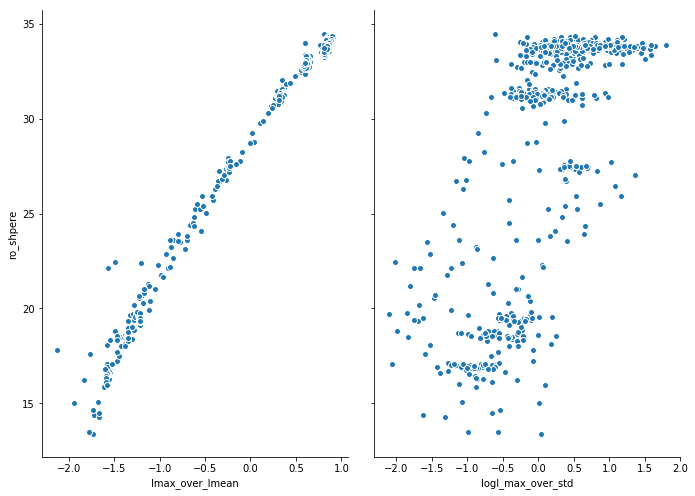

In [880]:
sns.pairplot(data_sphere, x_vars=[ 'Imax_over_Imean',  
                                 'logI_max_over_std'], y_vars='ro_shpere', size=7, aspect=0.7)

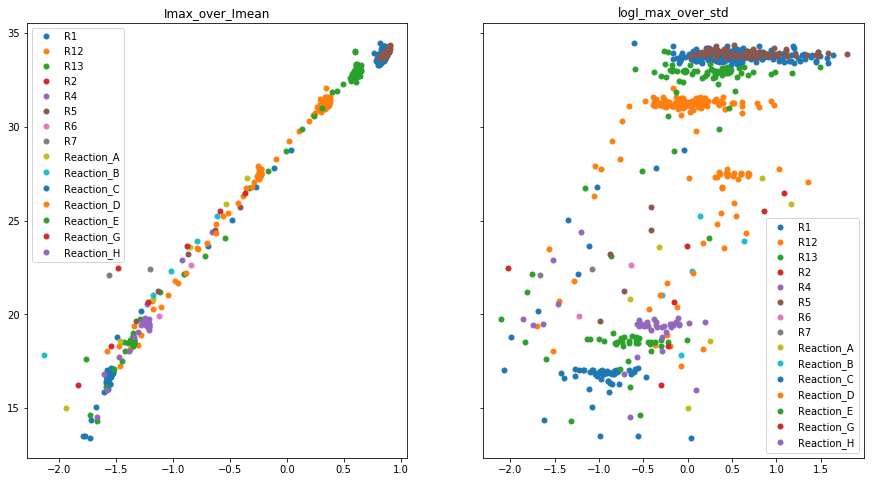

In [881]:
groups = data_sphere.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.ro_shpere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.ro_shpere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

#### Loss 

* ‘squared_loss’ ordinary least squares fit
* ‘huber’modifies ‘squared_loss’ to focus less on getting outliers correct by switching from squared to linear loss past a distance of epsilon.  
* ‘epsilon_insensitive’ignores errors less than epsilon and is linear past that; 
* ‘squared_epsilon_insensitive’is the same but becomes squared loss past a tolerance of epsilon.

**We have grouped data. From some experiments we have a lot of almost the same samples, but from some other experiments we have few uniqe data. Thus, I decided to use weighted loss function. Samples that are from the same experimets and that are close in the features space will have less weight that "single" samples.**

In [882]:
data_sphere.experiment_id.value_counts()

R1            234
R12           114
R13            74
R5             74
Reaction_C     53
Reaction_D     39
Reaction_H     37
Reaction_E     35
Reaction_A      6
Reaction_G      6
Reaction_B      5
R4              3
R6              2
R7              2
R2              1
Name: experiment_id, dtype: int64

Remouving outliers we lost data from R3

In [883]:
experiments = ['R1','R12','R13','R2','R4','R5','R6','R7','Reaction_A','Reaction_B',
               'Reaction_C','Reaction_D','Reaction_E','Reaction_G','Reaction_H']

### Using Kernel Density as weights

It calculates the density of features in a neighborhood around those features.

How might we determine the optimal bandwidth for any given problem?
https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/

I wil use cross validation to find 'bandwidth' that wil give me the maximum likelihood.

In [761]:
# Demo using only one feature:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['Imax_over_Imean']])
grid.best_params_

{'bandwidth': 0.044137931034482762}

In [762]:
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(data_sphere[[ 'Imax_over_Imean']])
kde3 = KernelDensity(kernel='gaussian', bandwidth=0.004).fit(data_sphere[[ 'Imax_over_Imean']])

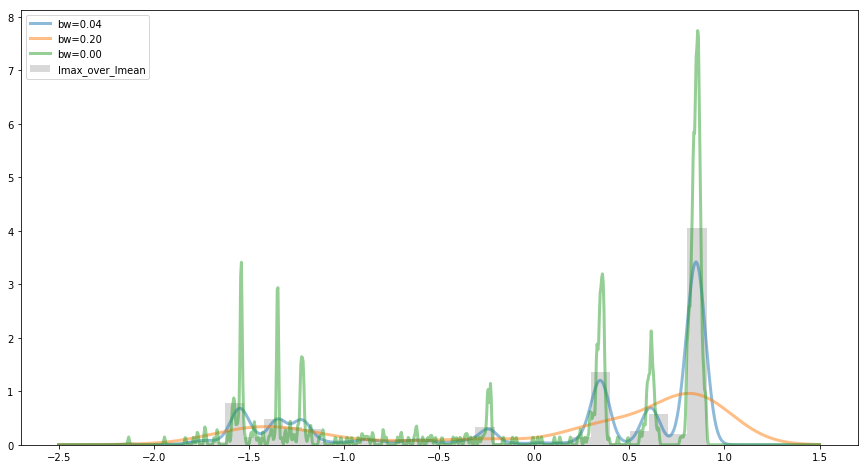

In [763]:
x_grid = np.linspace(-2.5, 1.5, 1000)

kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))
pdf1 = np.exp(kde1.score_samples(x_grid[:, None]))
pdf3 = np.exp(kde3.score_samples(x_grid[:, None]))

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_grid, pdf, linewidth=3, alpha=0.5, label='bw=%.2f' % kde.bandwidth)
ax.plot(x_grid, pdf1, linewidth=3, alpha=0.5, label='bw=%.2f' % kde1.bandwidth)
ax.plot(x_grid, pdf3, linewidth=3, alpha=0.5, label='bw=%.2f' % kde3.bandwidth)
ax.hist(data_sphere['Imax_over_Imean'], 30, fc='gray', histtype='stepfilled', alpha=0.3, normed=True)
ax.legend(loc='upper left')
#ax.set_xlim(-4.5, 3.5);

GridSearch gives us a good value for bandwidth. Blue line (bw = 0.04) is the most reasonable. 

To calculate kernel density for our training data, I will use 'ro_shpere',  'logI_max_over_std', and 'Imax_over_Imean'.

In [764]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])
grid.best_params_

{'bandwidth': 0.18068965517241381}

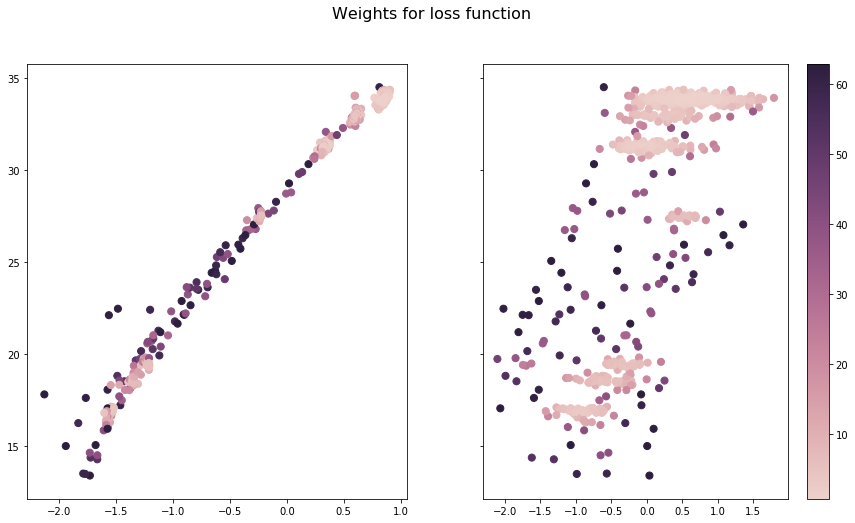

In [886]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.18).fit(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])

# score_samples() returns the log-likelihood of the samples
log_pdf = kde.score_samples(data_sphere[['ro_shpere',  'logI_max_over_std', 'Imax_over_Imean']])
sc = 1/np.exp(log_pdf)

data_sphere['weights'] = sc

cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.ro_shpere, c=sc, s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.logI_max_over_std, data_sphere.ro_shpere, c=sc, s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

### Grid search for the best model

In [887]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['logI_max_over_std', 'Imax_over_Imean']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0.01, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  0.361


In [888]:
std_ro_shpere = data_sphere_test['ro_shpere'].std()

In [889]:
features = ['logI_max_over_std', 'Imax_over_Imean']

test_scores_by_ex = []
stat_dic = {}
count = 0 # we have 120 combinations
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001, loss= 'squared_loss', penalty = 'l2')
        reg.fit(tr[features], tr['ro_shpere'], sample_weight=tr['weights'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.867340320393
test score mean squared error normalized:  0.135850050494

Testing on:  R12
R2 score:  0.800098432868
test score mean squared error normalized:  0.0685947801925

Testing on:  R13
R2 score:  0.883948886316
test score mean squared error normalized:  0.0834258967849

Testing on:  R2
R2 score:  -4.83025211197
test score mean squared error normalized:  1.46336966474

Testing on:  R4
R2 score:  0.755992560324
test score mean squared error normalized:  0.213774730425

Testing on:  R5
R2 score:  0.879480519853
test score mean squared error normalized:  0.227604393758

Testing on:  R6
R2 score:  -2.8808684699
test score mean squared error normalized:  0.303030519291

Testing on:  R7
R2 score:  0.742214026875
test score mean squared error normalized:  0.138162150234

Testing on:  Reaction_A
R2 score:  0.919469580039
test score mean squared error normalized:  0.164438462494

Testing on:  Reaction_B
R2 score:  0.217355032321
test score mean squared error n

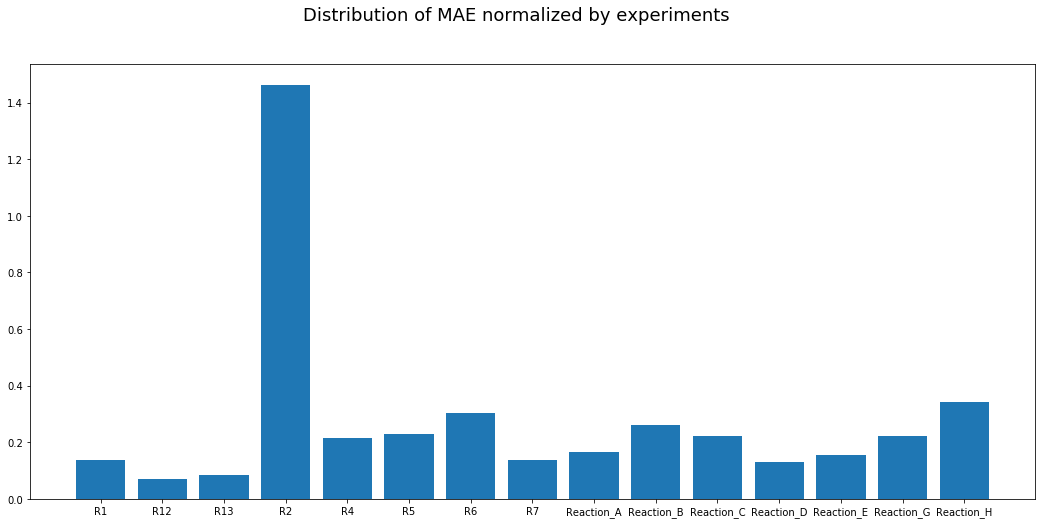

In [890]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

We have only one sample in the experiment R2.

### Using all features

In [838]:
features_label = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std','ro_shpere' ]
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[features])
grid.best_params_

{'bandwidth': 0.14655172413793105}

In [891]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.14655).fit(data_sphere[features_label])

log_pdf = kde.score_samples(data_sphere[features_label])
sc = 1/np.exp(log_pdf)

data_sphere['weights_5_features'] = sc

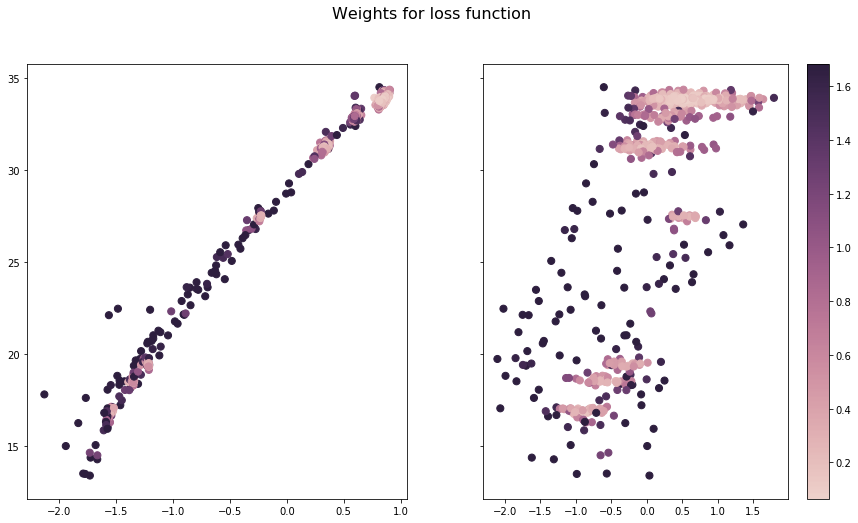

In [892]:
cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.ro_shpere, c=data_sphere['weights_5_features'], s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.logI_max_over_std, data_sphere.ro_shpere, c=data_sphere['weights_5_features'], s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

It looks like that weights we got using kde with only two features is better that this one (using 5 features).

#### Using weights from 5 features

In [893]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights_5_features'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.001, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  -4.656


We got a very bad R2

#### Now I will try to use weights that I got from 2 features

In [894]:
parameters = {'loss':('huber', 'squared_loss'), # huber with epsilon = 0 gives us abs error (MAE)
              'epsilon': [1, 0.1, 0.01, 0.001, 0],
              'penalty':['none', 'l2', 'l1', 'elasticnet'], #default l2
              'alpha':[0.0001, 0.001, 0.01], #default 0.0001
             'l1_ratio': [0, 0.15, 0.5, 0.95], #default 0.15
             }

cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['ro_shpere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['ro_shpere'],  sample_weight = data_sphere['weights'])
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 1, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'elasticnet'}
Training score R2:  0.657


In [898]:
features

['q_Imax',
 'Imax_over_Imean',
 'Imax_sharpness',
 'logI_fluctuation',
 'logI_max_over_std']

In [895]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'elasticnet', l1_ratio = 0.95)
        reg.fit(tr[features], tr['ro_shpere'], sample_weight=tr['weights'])
        test_r2 = reg.score(test[features], test['ro_shpere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['ro_shpere'])
        print('test score mean squared error normalized: ', test_score / std_ro_shpere)
        test_scores_by_ex.append(test_score/std_ro_shpere)
        stat_dic[experiments[i]] = test_score/std_ro_shpere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.816079547569
test score mean squared error normalized:  0.157319454377

Testing on:  R12
R2 score:  0.984884354536
test score mean squared error normalized:  0.0455424085412

Testing on:  R13
R2 score:  0.937648729846
test score mean squared error normalized:  0.0894050821635

Testing on:  R2
R2 score:  -0.425889315252
test score mean squared error normalized:  0.761160448304

Testing on:  R4
R2 score:  0.903516034269
test score mean squared error normalized:  0.140920143628

Testing on:  R5
R2 score:  0.869370525907
test score mean squared error normalized:  0.165952771402

Testing on:  R6
R2 score:  -23.2133707166
test score mean squared error normalized:  0.807318766311

Testing on:  R7
R2 score:  -0.28037415106
test score mean squared error normalized:  0.373718447888

Testing on:  Reaction_A
R2 score:  0.940794938396
test score mean squared error normalized:  0.141363437879

Testing on:  Reaction_B
R2 score:  0.894724096388
test score mean squared erro

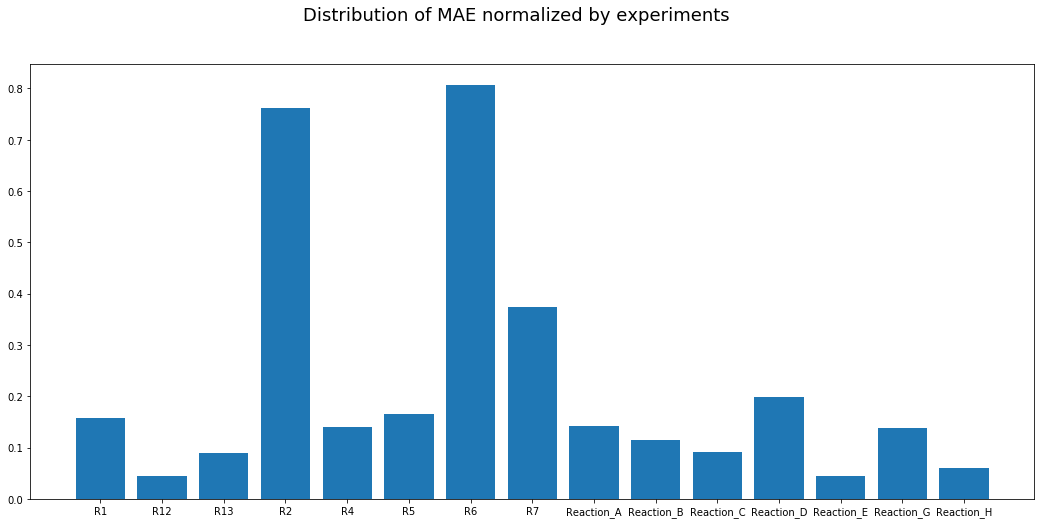

In [896]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

**We got the best result using weighted regression with five features, but I used only two features to calculate the weights**

In [897]:
reg.coef_

array([ 1.10085   ,  7.36490203,  0.12877213, -0.1378883 ,  0.13264946])

All features make some contribution into result. **Imax_over_Imean** it the most important feature.

### Sigma-sphere

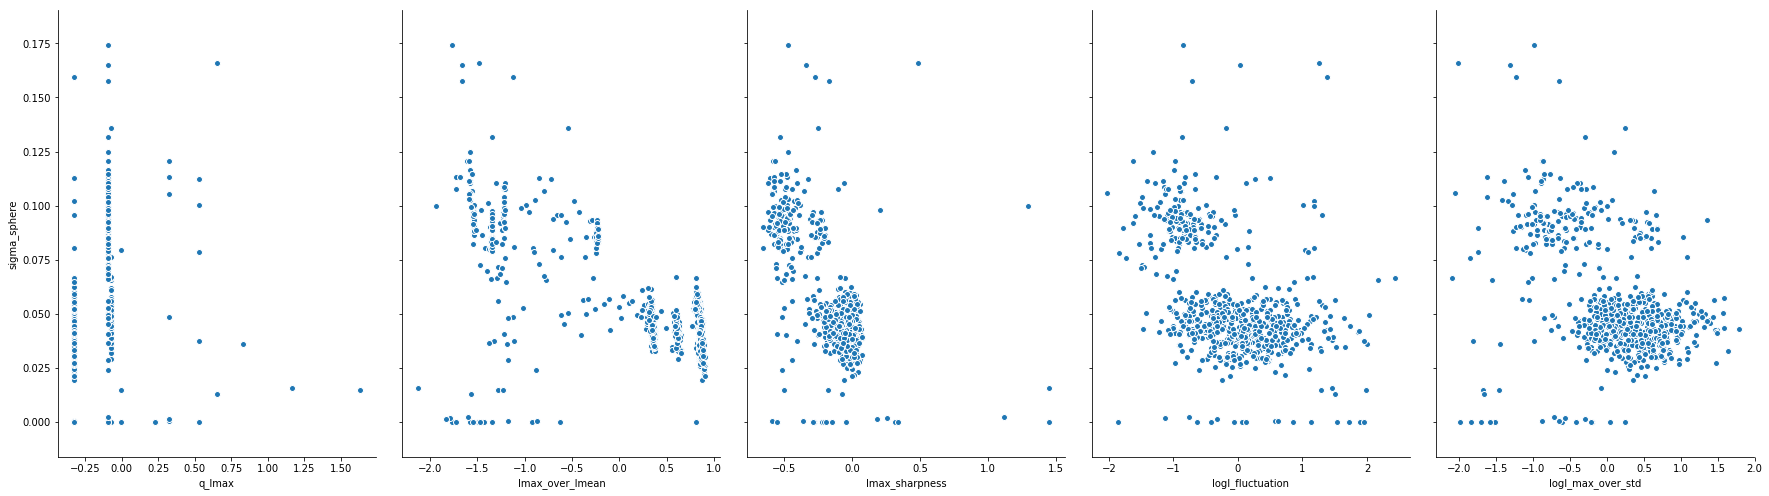

In [899]:
sns.pairplot(data_sphere, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='sigma_sphere', size=7, aspect=0.7)

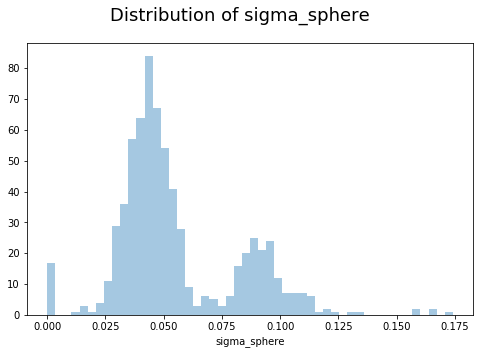

In [900]:
plt.figure(figsize=(8,5))
sns.distplot(data_sphere['sigma_sphere'], kde=False, bins=50)
plt.suptitle("Distribution of sigma_sphere ", fontsize=18)

In [848]:
# we need to remove all samples with 'sigma_sphere' == 0
data_sphere = data_sphere[data_sphere['sigma_sphere'] > 0.01]
data_sphere.shape

(668, 10)

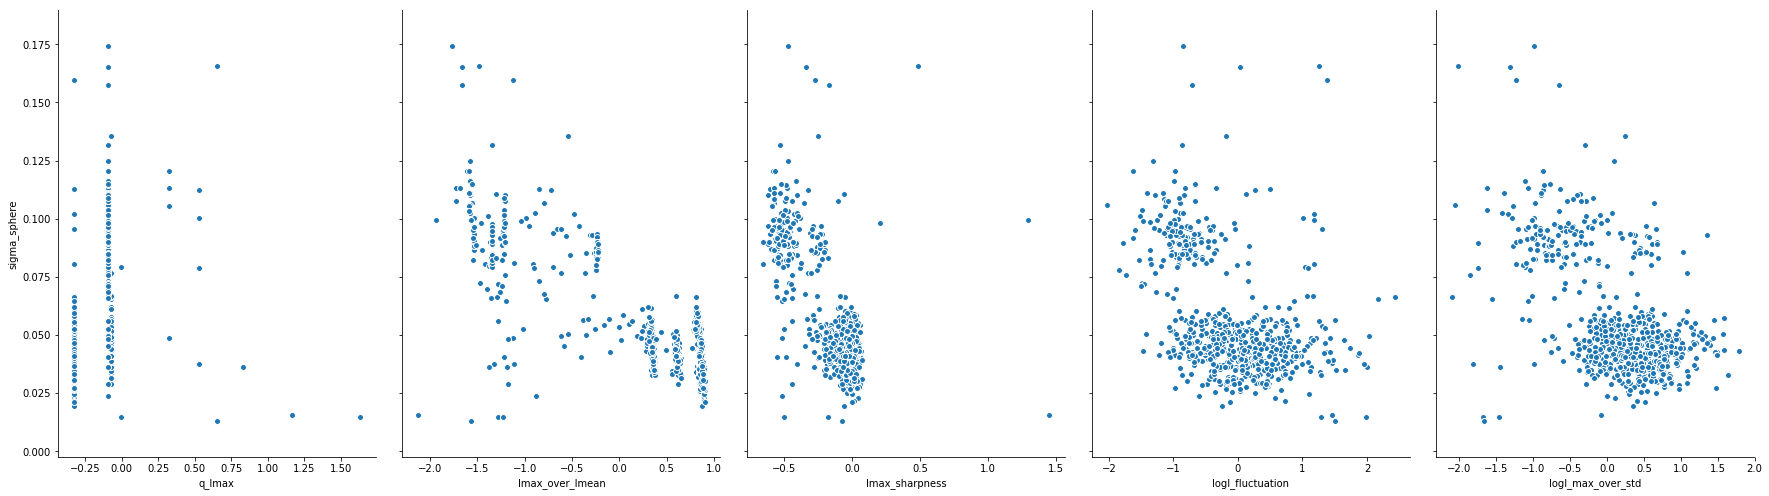

In [859]:
sns.pairplot(data_sphere, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='sigma_sphere', size=7, aspect=0.7)

In [901]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=10000)
    reg.fit(data_sphere[[f]], data_sphere['sigma_sphere'])
    pred = reg.predict(data_sphere[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_sphere['sigma_sphere'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_sphere['sigma_sphere'], pred))

Mean squared error: 0.00067
Variance score: 0.05163
Mean squared error: 0.00041
Variance score: 0.42002
Mean squared error: 0.00043
Variance score: 0.38708
Mean squared error: 0.00057
Variance score: 0.19365
Mean squared error: 0.00058
Variance score: 0.17632


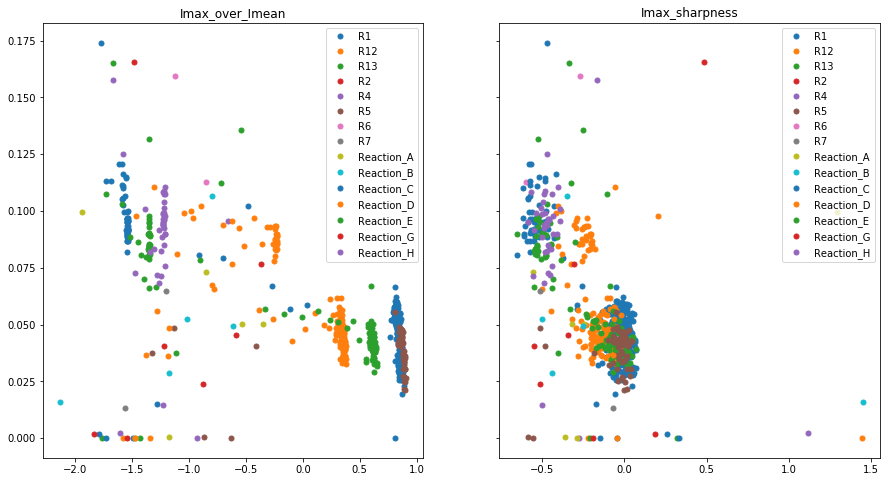

In [902]:
groups = data_sphere.groupby('experiment_id')

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.Imax_over_Imean, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('Imax_over_Imean')
ax1.legend()

for name, group in groups:
    ax2.plot(group.Imax_sharpness, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('Imax_sharpness')
ax2.legend()

plt.show()

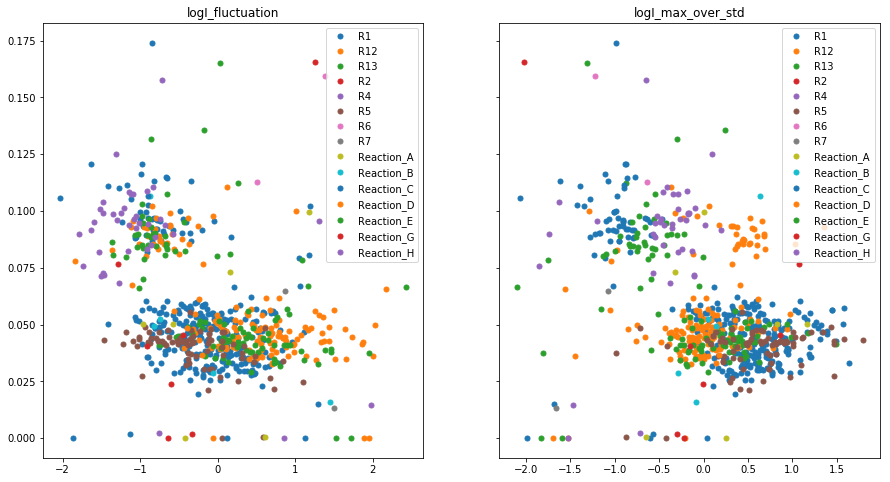

In [903]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)
for name, group in groups:
    ax1.plot(group.logI_fluctuation, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax1.set_title('logI_fluctuation')
ax1.legend()

for name, group in groups:
    ax2.plot(group.logI_max_over_std, group.sigma_sphere, marker='o', linestyle='', ms=5, label=name)
ax2.set_title('logI_max_over_std')
ax2.legend()

plt.show()

I will use only 'Imax_over_Imean'and 'Imax_sharpness' to calculate the weights since we have "groupping" in thes two features.

In [904]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.01, 1.0, 30)}, # 30 numbers from 0.01 to 1 
                    cv=10) # 10-fold cross-validation
grid.fit(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])
grid.best_params_

{'bandwidth': 0.044137931034482762}

In [905]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.044).fit(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])

log_pdf = kde.score_samples(data_sphere[['sigma_sphere',  'Imax_over_Imean', 'Imax_sharpness']])
sc = 1/np.exp(log_pdf)

data_sphere['weights_sigma_sphere_2_features'] = sc

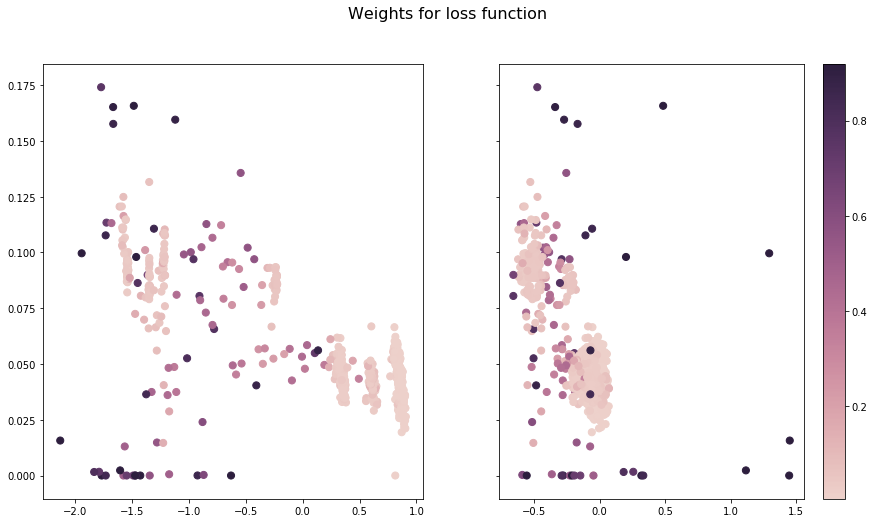

In [906]:
cmap = sns.cubehelix_palette(as_cmap=True)

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(15,8))
ax1.margins(0.05) # Optional, just adds 5% padding to the autoscaling
ax2.margins(0.05)

points1 = ax1.scatter(data_sphere.Imax_over_Imean, data_sphere.sigma_sphere, c=data_sphere['weights_sigma_sphere_2_features'], s=50, cmap=cmap)
points2 = ax2.scatter(data_sphere.Imax_sharpness, data_sphere.sigma_sphere, c=data_sphere['weights_sigma_sphere_2_features'], s=50, cmap=cmap)
fig.colorbar(points1)

plt.suptitle('Weights for loss function', fontsize=16)

In [910]:
cv=LeavePGroupsOut(n_groups=1).split(data_sphere[features], data_sphere[['sigma_sphere']], groups=data_sphere['experiment_id'])

features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor()
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_sphere[features], data_sphere['sigma_sphere'])
#clf.fit(data_sphere[features], data_sphere['ro_shpere']) # Training score R2:  -2.254
print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.1, 'l1_ratio': 0.95, 'loss': 'squared_loss', 'penalty': 'l2'}
Training score R2:  -0.310


With weights we had R2 = -3.93

In [911]:
std_sigma_sphere = data_sphere_test['sigma_sphere'].std()

In [912]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_sphere[(data_sphere['experiment_id']!= experiments[i]) ]
        test = data_sphere_test[(data_sphere_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['sigma_sphere'])
        test_r2 = reg.score(test[features], test['sigma_sphere'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['sigma_sphere'])
        print('test score mean squared error normalized: ', test_score / std_sigma_sphere)
        test_scores_by_ex.append(test_score/std_sigma_sphere)
        stat_dic[experiments[i]] = test_score/std_sigma_sphere
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  0.0515380171278
test score mean squared error normalized:  0.307885101929

Testing on:  R12
R2 score:  -0.552665403131
test score mean squared error normalized:  0.315476946473

Testing on:  R13
R2 score:  0.0558906502504
test score mean squared error normalized:  0.320259231395

Testing on:  R2
R2 score:  -1.34715482625
test score mean squared error normalized:  3.64307469776

Testing on:  R4
R2 score:  -0.59198316592
test score mean squared error normalized:  1.52277953067

Testing on:  R5
R2 score:  -4.61105629065
test score mean squared error normalized:  0.491522673509

Testing on:  R6
R2 score:  0.424585254357
test score mean squared error normalized:  1.38796235385

Testing on:  R7
R2 score:  -3.19848281256
test score mean squared error normalized:  3.6419906994

Testing on:  Reaction_A
R2 score:  -0.800559505709
test score mean squared error normalized:  1.34351805407

Testing on:  Reaction_B
R2 score:  0.00259126561959
test score mean squared error n

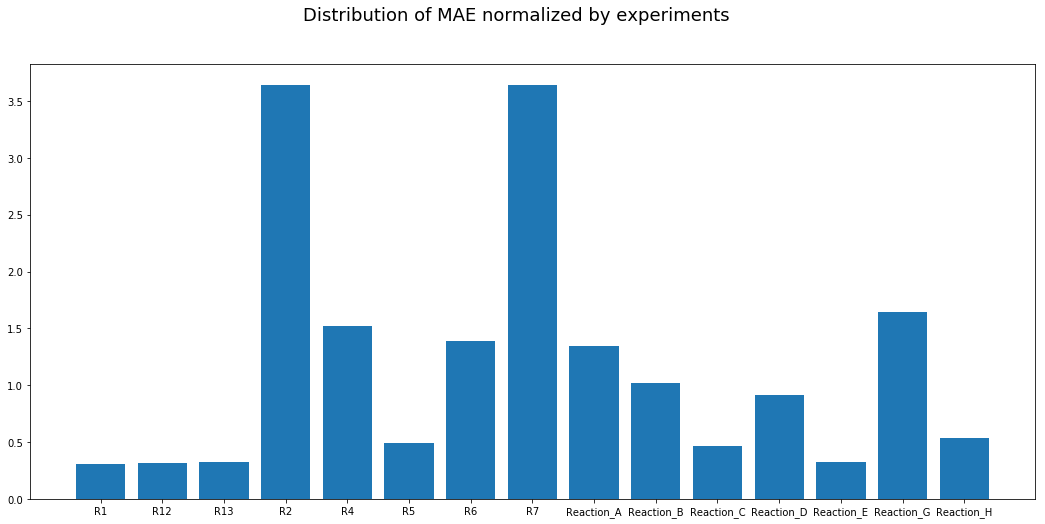

In [913]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

## Precursor paramentrs
### G_precursor

In [914]:
# I will use only data with precursor= True and struture = False
data_precursor = data[(data['precursor']== True) & (data['structure']==False)]
data_precursor.shape

(518, 14)

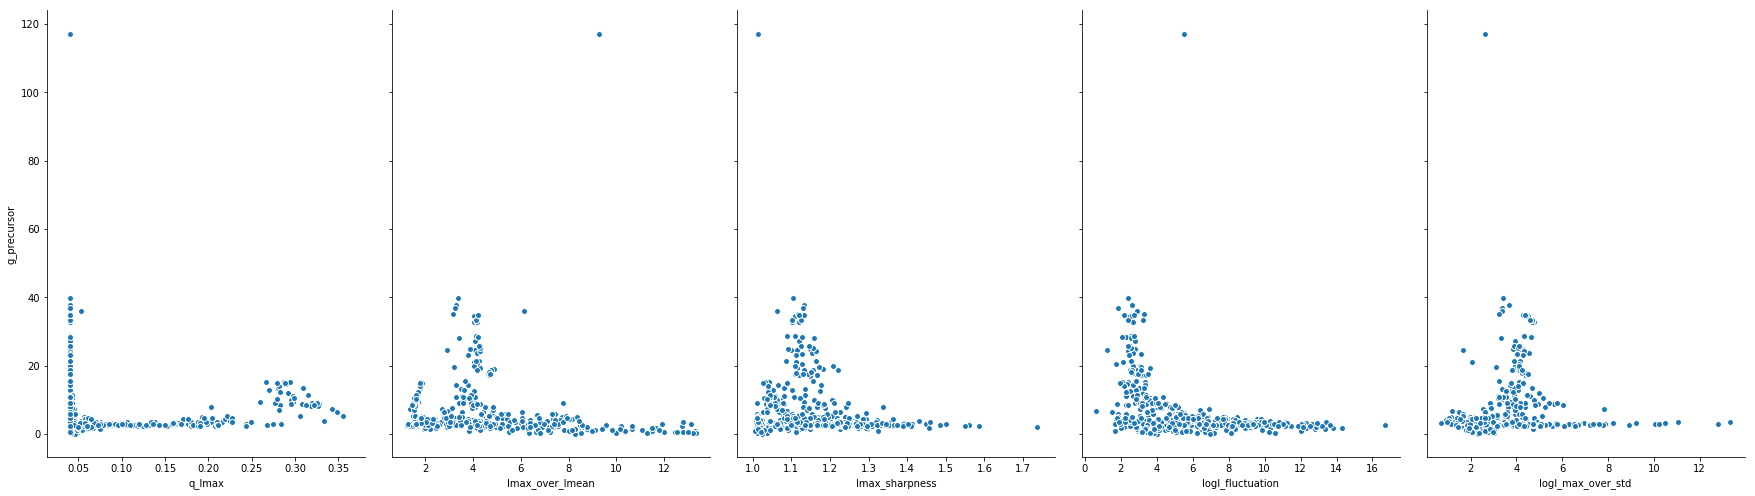

In [915]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='g_precursor', size=7, aspect=0.7)

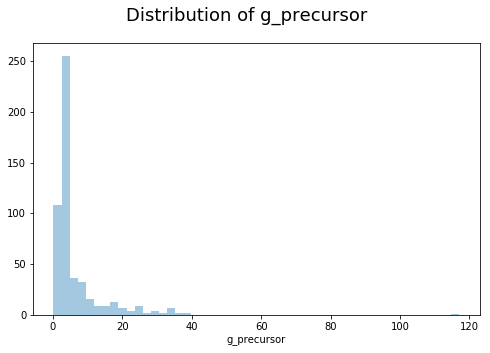

In [916]:
plt.figure(figsize=(8,5))
sns.distplot(data_precursor['g_precursor'], kde=False, bins=50)
plt.suptitle("Distribution of g_precursor ", fontsize=18)

In [921]:
data_precursor.columns

Index(['experiment_id', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std', 'bad_data', 'form',
       'precursor', 'structure', 'ro_shpere', 'sigma_sphere', 'g_precursor',
       'rg_precursor'],
      dtype='object')

In [922]:
#remove outliers for target variables only
labels = ['g_precursor','rg_precursor']
st =  data_precursor[labels].std()
m = data_precursor[labels].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[labels].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(500, 8)

In [924]:
data_precursor_test = data_precursor

# training data: remove outliers from features

cols = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness',
       'logI_fluctuation', 'logI_max_over_std']

st =  data_precursor[cols].std()
m = data_precursor[cols].mean()

# remove outliers that is out of range +/- 2.5 std
filt_df = data_precursor[cols].apply(lambda x: x[(x >  m[x.name] - 2.5 * st[x.name]  ) & 
                                    (x < m[x.name] + 2.5 * st[x.name])], axis=0)

c = ['experiment_id', 'g_precursor','rg_precursor']
data_precursor = pd.concat([data_precursor.loc[:,c], filt_df], axis=1)
data_precursor.dropna(inplace=True)
data_precursor.shape

(426, 8)

In [927]:
data_precursor.experiment_id.value_counts()

Reaction_B    43
Reaction_D    42
Reaction_C    40
Reaction_H    39
R2            37
R7            37
Reaction_E    33
R4            33
Reaction_G    32
R6            30
R5            24
Reaction_A    20
R3            11
R1             5
Name: experiment_id, dtype: int64

In [917]:
experiments = ['R1', 'R3',
 'R2',
 'R4',
 'R5',
 'R6',
 'R7',
 'Reaction_A',
 'Reaction_B',
 'Reaction_C',
 'Reaction_D',
 'Reaction_E',
 'Reaction_G',
 'Reaction_H']

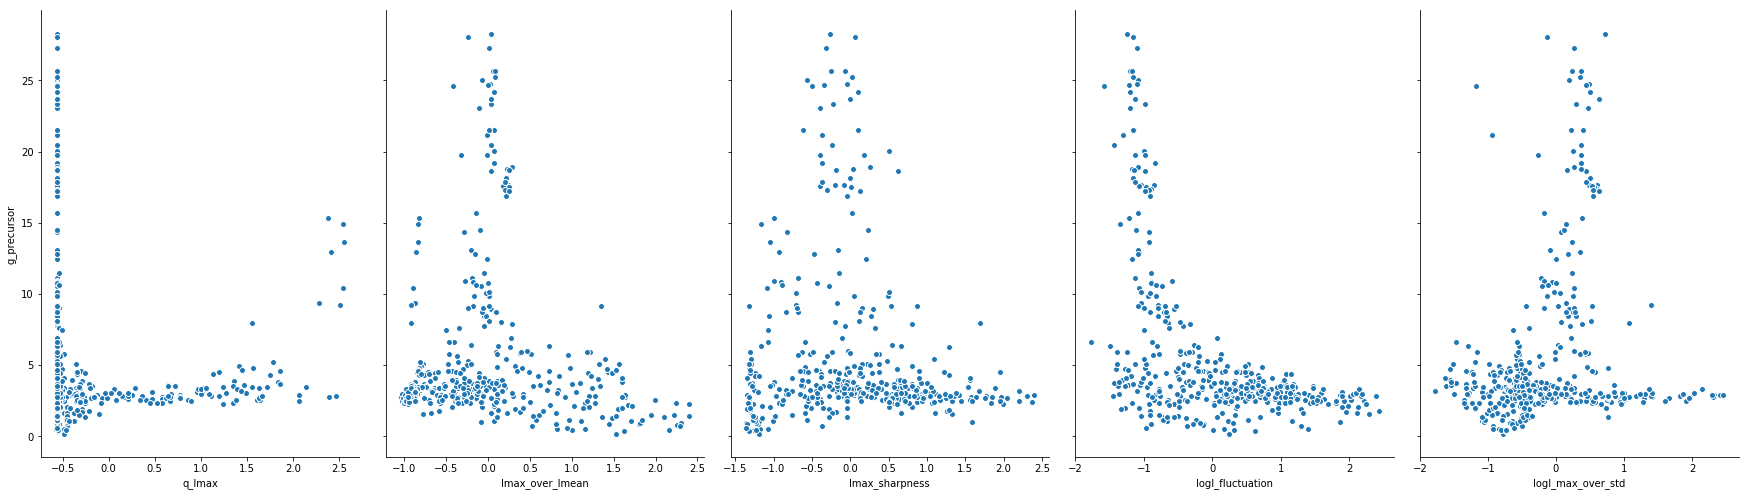

In [925]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='g_precursor', size=7, aspect=0.7)

In [926]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor()
    reg.fit(data_precursor[[f]], data_precursor['g_precursor'])
    pred = reg.predict(data_precursor[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_precursor['g_precursor'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_precursor['g_precursor'], pred))

Mean squared error: 30.39175
Variance score: 0.01054
Mean squared error: 30.67388
Variance score: 0.00135
Mean squared error: 30.42915
Variance score: 0.00932
Mean squared error: 22.31174
Variance score: 0.27360
Mean squared error: 29.52473
Variance score: 0.03876


We can try to use 1/'logI_fluctuation'

In [937]:
data_precursor['1/logI_fluctration'] = (1 / (data_precursor['logI_fluctuation'] +2)) 
data_precursor_test['1/logI_fluctration'] = (1 / (data_precursor_test['logI_fluctuation'] +2)) 

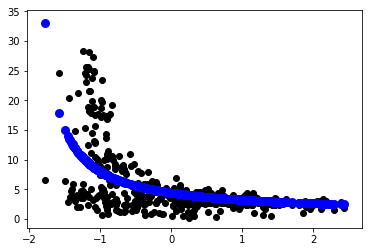

In [932]:
reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/logI_fluctration']], data_precursor['g_precursor'])
pred = reg.predict(data_precursor[['1/logI_fluctration']])
plt.scatter(data_precursor['logI_fluctuation'], data_precursor['g_precursor'],  color='black')
plt.scatter(data_precursor['logI_fluctuation'], pred, color='blue', linewidth=3)

In [935]:
std_g_precursor = data_precursor['g_precursor'].std()

In [938]:
features = ['1/logI_fluctration']
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -168.896988078
test score mean squared error normalized:  0.687765274617

Testing on:  R3
R2 score:  -0.225700132069
test score mean squared error normalized:  0.580284674224

Testing on:  R2
R2 score:  -1.75358533762
test score mean squared error normalized:  0.227082301227

Testing on:  R4
R2 score:  -9.58342258377
test score mean squared error normalized:  0.440362679081

Testing on:  R5
R2 score:  -11.3967794582
test score mean squared error normalized:  0.459400445017

Testing on:  R6
R2 score:  -11.7107630018
test score mean squared error normalized:  0.394834258777

Testing on:  R7
R2 score:  -2.00729993983
test score mean squared error normalized:  0.212293007529

Testing on:  Reaction_A
R2 score:  -0.11089499193
test score mean squared error normalized:  1.00177005768

Testing on:  Reaction_B
R2 score:  -0.0793275005426
test score mean squared error normalized:  1.18551415402

Testing on:  Reaction_C
R2 score:  -0.0796745806646
test score mean square

In [950]:
features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -13.8850848094
test score mean squared error normalized:  0.188392346674

Testing on:  R3
R2 score:  -0.385223605624
test score mean squared error normalized:  0.629617403874

Testing on:  R2
R2 score:  -2.95604959822
test score mean squared error normalized:  0.255949170081

Testing on:  R4
R2 score:  -24.5715515661
test score mean squared error normalized:  0.63801010875

Testing on:  R5
R2 score:  -54.3825357629
test score mean squared error normalized:  0.948898378555

Testing on:  R6
R2 score:  -15.4718554728
test score mean squared error normalized:  0.40377026811

Testing on:  R7
R2 score:  -6.5616851697
test score mean squared error normalized:  0.333106645756

Testing on:  Reaction_A
R2 score:  0.28347896006
test score mean squared error normalized:  0.717340403894

Testing on:  Reaction_B
R2 score:  0.196636253283
test score mean squared error normalized:  0.985359152162

Testing on:  Reaction_C
R2 score:  0.260979214464
test score mean squared erro

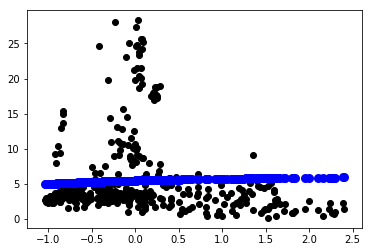

In [940]:
data_precursor['1/Imax_over_Imean'] = (1 / (data_precursor['Imax_over_Imean'] +3)) 
data_precursor_test['1/Imax_over_Imean'] = (1 / (data_precursor_test['Imax_over_Imean'] +3)) 

reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['1/Imax_over_Imean']], data_precursor['g_precursor'])
pred = reg.predict(data_precursor[['1/Imax_over_Imean']])
plt.scatter(data_precursor['Imax_over_Imean'], data_precursor['g_precursor'],  color='black')
plt.scatter(data_precursor['Imax_over_Imean'], pred, color='blue', linewidth=3)

**1/Imax_over_Imean** does not work

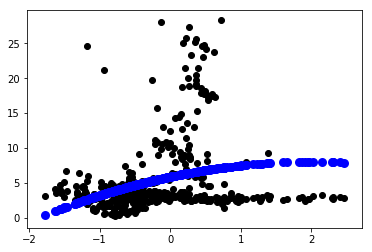

In [942]:
data_precursor['logI_max_over_std_squred'] = ( (data_precursor['logI_max_over_std'] - 2) ** 2) 
data_precursor_test['logI_max_over_std_squred'] = ( (data_precursor_test['logI_max_over_std'] - 2) ** 2)  

reg = linear_model.SGDRegressor(max_iter=1000)
reg.fit(data_precursor[['logI_max_over_std_squred']], data_precursor['g_precursor'])
pred = reg.predict(data_precursor[['logI_max_over_std_squred']])
plt.scatter(data_precursor['logI_max_over_std'], data_precursor['g_precursor'],  color='black')
plt.scatter(data_precursor['logI_max_over_std'], pred, color='blue', linewidth=3)

logI_max_over_std_squred' also does not work.

In [944]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.001, 'epsilon': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -1.373


In [953]:
features = ['1/logI_fluctration', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.001, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -14.7243618202
test score mean squared error normalized:  0.187368993889

Testing on:  R3
R2 score:  -0.451072341412
test score mean squared error normalized:  0.645684953211

Testing on:  R2
R2 score:  -2.93036812494
test score mean squared error normalized:  0.256275841842

Testing on:  R4
R2 score:  -25.1433827464
test score mean squared error normalized:  0.644994594455

Testing on:  R5
R2 score:  -56.9658299082
test score mean squared error normalized:  0.970122950666

Testing on:  R6
R2 score:  -15.8985675647
test score mean squared error normalized:  0.409529066658

Testing on:  R7
R2 score:  -6.73652578075
test score mean squared error normalized:  0.33642350416

Testing on:  Reaction_A
R2 score:  0.290326640226
test score mean squared error normalized:  0.712523488227

Testing on:  Reaction_B
R2 score:  0.200069932167
test score mean squared error normalized:  0.984425704656

Testing on:  Reaction_C
R2 score:  0.257944703959
test score mean squared e

In [946]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['g_precursor']], groups=data_precursor['experiment_id'])

features = ['1/logI_fluctration']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['g_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0.01, 'l1_ratio': 0.15, 'loss': 'huber', 'penalty': 'none'}
Training score R2:  -1.308


In [952]:
features = ['1/logI_fluctration']

test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001, loss= 'huber',epsilon= 0.01, penalty= 'l2')
        reg.fit(tr[features], tr['g_precursor'])
        test_r2 = reg.score(test[features], test['g_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['g_precursor'])
        print('test score mean squared error normalized: ', test_score / std_g_precursor)
        test_scores_by_ex.append(test_score/std_g_precursor)
        stat_dic[experiments[i]] = test_score/std_g_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -3.50598725461
test score mean squared error normalized:  0.0997235705641

Testing on:  R3
R2 score:  -7.75433593511
test score mean squared error normalized:  1.74470267091

Testing on:  R2
R2 score:  -13.4197080125
test score mean squared error normalized:  0.571392346322

Testing on:  R4
R2 score:  -8.21782282181
test score mean squared error normalized:  0.418943551844

Testing on:  R5
R2 score:  -8.28031155132
test score mean squared error normalized:  0.418988958847

Testing on:  R6
R2 score:  -14.2232869076
test score mean squared error normalized:  0.451869095098

Testing on:  R7
R2 score:  -17.9302056797
test score mean squared error normalized:  0.617704741042

Testing on:  Reaction_A
R2 score:  -1.72139640187
test score mean squared error normalized:  1.87011734589

Testing on:  Reaction_B
R2 score:  -1.275684794
test score mean squared error normalized:  1.87646270733

Testing on:  Reaction_C
R2 score:  -1.72296238508
test score mean squared error

We got about the best result using o all 6 features.

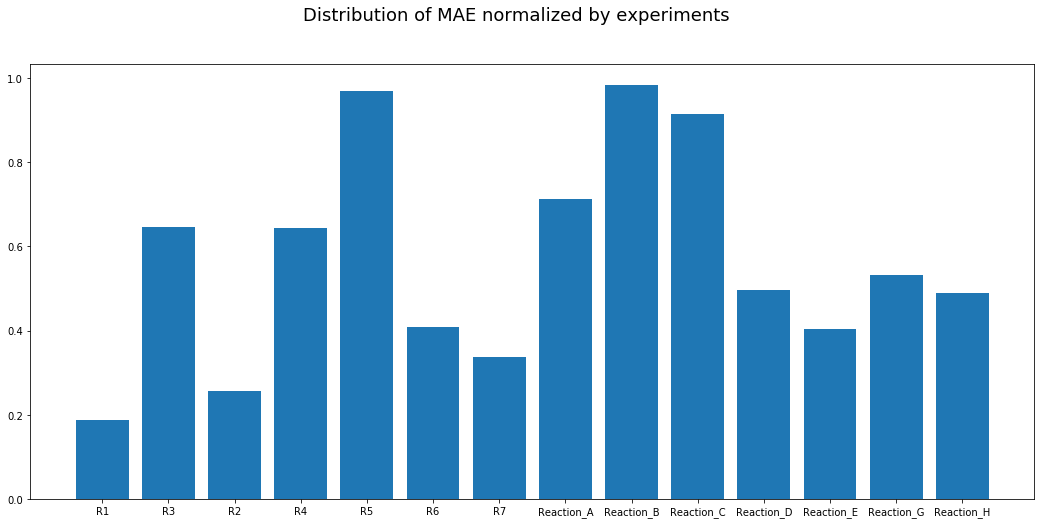

In [954]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()

### rg_precursor

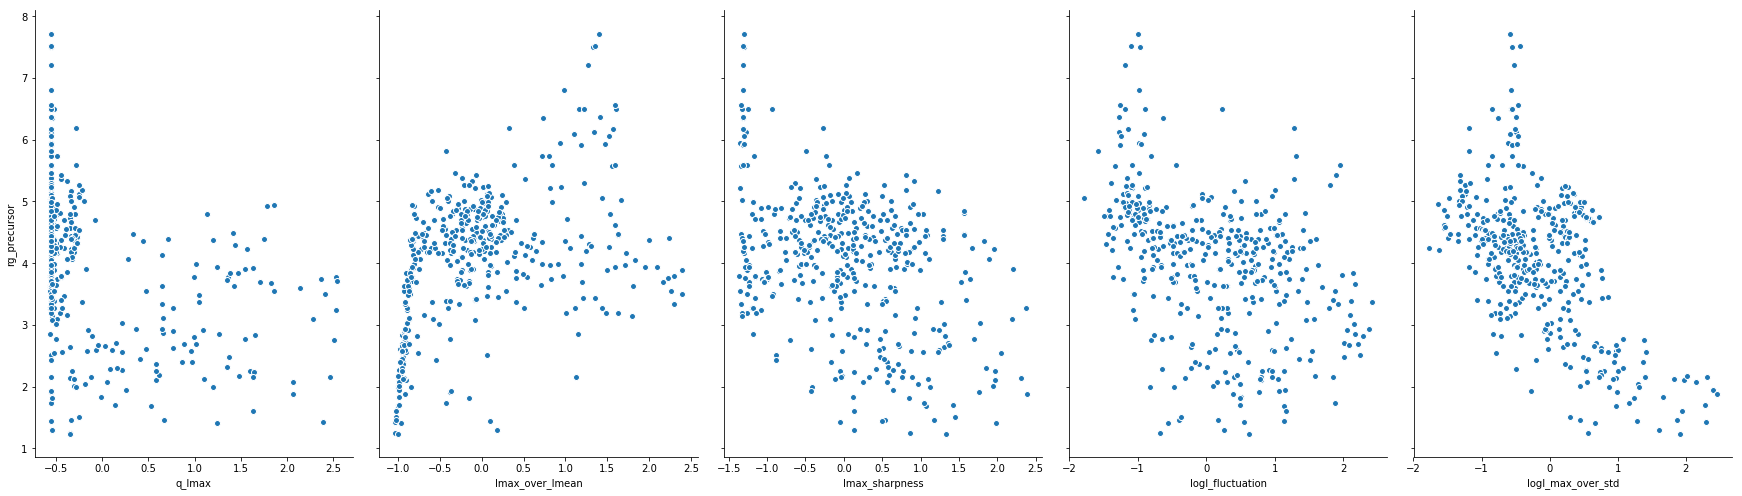

In [955]:
sns.pairplot(data_precursor, x_vars=['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std'], y_vars='rg_precursor', size=7, aspect=0.7)

In [956]:
features = ['q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 'logI_max_over_std']

for f in features:
    reg = linear_model.SGDRegressor(max_iter=1000)
    reg.fit(data_precursor[[f]], data_precursor['rg_precursor'])
    pred = reg.predict(data_precursor[[f]])
    print("Mean squared error: %.5f"
      % mean_squared_error(data_precursor['rg_precursor'], pred))
    # Explained variance score: 1 is perfect prediction
    print('Variance score: %.5f' % r2_score(data_precursor['rg_precursor'], pred))

Mean squared error: 1.02942
Variance score: 0.16674
Mean squared error: 0.97604
Variance score: 0.20994
Mean squared error: 1.02318
Variance score: 0.17179
Mean squared error: 1.00477
Variance score: 0.18669
Mean squared error: 0.82337
Variance score: 0.33352


In [957]:
data_precursor['logI_max_over_std_squred'] = ( (data_precursor['logI_max_over_std'] - 2) ** 2) 
data_precursor_test['logI_max_over_std_squred'] = ( (data_precursor_test['logI_max_over_std'] - 2) ** 2) 

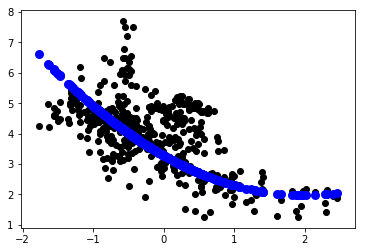

In [958]:
reg = linear_model.SGDRegressor(max_iter=10000, loss = 'huber', epsilon = 0.005)
reg.fit(data_precursor[['logI_max_over_std_squred']], data_precursor['rg_precursor'])
pred = reg.predict(data_precursor[['logI_max_over_std_squred']])
plt.scatter(data_precursor['logI_max_over_std'], data_precursor['rg_precursor'],  color='black')
plt.scatter(data_precursor['logI_max_over_std'], pred, color='blue', linewidth=3)

In [959]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_precursor']], groups=data_precursor['experiment_id'])

features = ['logI_max_over_std_squred']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.01, 'epsilon': 1, 'l1_ratio': 0, 'loss': 'squared_loss', 'penalty': 'elasticnet'}
Training score R2:  -1.410


In [960]:
std_rg_precursor = data_precursor['rg_precursor'].std()

In [968]:
features = ['logI_max_over_std_squred']
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.01, loss= 'squared_loss', penalty= 'l2')
        reg.fit(tr[features], tr['rg_precursor'])
        test_r2 = reg.score(test[features], test['rg_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_precursor'])
        print('test score mean squared error normalized: ', test_score / std_rg_precursor)
        test_scores_by_ex.append(test_score/std_rg_precursor)
        stat_dic[experiments[i]] = test_score/std_rg_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.842923244777
test score mean squared error normalized:  0.913553104529

Testing on:  R3
R2 score:  -1.67026723991
test score mean squared error normalized:  0.52936155688

Testing on:  R2
R2 score:  -1.84258731289
test score mean squared error normalized:  0.761193818121

Testing on:  R4
R2 score:  -0.446207688302
test score mean squared error normalized:  0.387144339432

Testing on:  R5
R2 score:  -2.24397173677
test score mean squared error normalized:  1.02671328035

Testing on:  R6
R2 score:  0.258934143379
test score mean squared error normalized:  0.329987358617

Testing on:  R7
R2 score:  -0.456774784891
test score mean squared error normalized:  0.441241796029

Testing on:  Reaction_A
R2 score:  -7.06576691105
test score mean squared error normalized:  1.34731428801

Testing on:  Reaction_B
R2 score:  -8.87831200902
test score mean squared error normalized:  0.993448735359

Testing on:  Reaction_C
R2 score:  -4.53073896266
test score mean squared e

In [962]:
cv=LeavePGroupsOut(n_groups=1).split(data_precursor[features], data_precursor[['rg_precursor']], groups=data_precursor['experiment_id'])

features = ['logI_max_over_std_squred', 'q_Imax', 'Imax_over_Imean', 'Imax_sharpness','logI_fluctuation', 
                                 'logI_max_over_std']

reg = linear_model.SGDRegressor(max_iter=1000)
clf = GridSearchCV(reg, parameters, cv=cv)
    
clf.fit(data_precursor[features], data_precursor['rg_precursor'])

print("Best parameters set found on training set:")
print(clf.best_params_)
    
print("Training score R2: ","%0.3f" %  clf.best_score_)#Cross-validated score on training set

Best parameters set found on training set:
{'alpha': 0.0001, 'epsilon': 0.1, 'l1_ratio': 0.15, 'loss': 'squared_loss', 'penalty': 'none'}
Training score R2:  -0.443


In [967]:
test_scores_by_ex = []
stat_dic = {}
count = 0 
for i in range(len(experiments)):
        print("Testing on: ", experiments[i])
        tr = data_precursor[(data_precursor['experiment_id']!= experiments[i]) ]
        test = data_precursor_test[(data_precursor_test['experiment_id']== experiments[i]) ]
        
        reg = linear_model.SGDRegressor(alpha= 0.0001, loss= 'squared_loss', penalty= 'none')
        reg.fit(tr[features], tr['rg_precursor'])
        test_r2 = reg.score(test[features], test['rg_precursor'])
        print("R2 score: ", test_r2)
        pr = reg.predict(test[features])
        test_score = mean_absolute_error(pr, test['rg_precursor'])
        print('test score mean squared error normalized: ', test_score / std_rg_precursor)
        test_scores_by_ex.append(test_score/std_rg_precursor)
        stat_dic[experiments[i]] = test_score/std_rg_precursor
        count +=1
        print()
       
print("Average testing mean absolute error normalized: ", sum(test_scores_by_ex)/count)

Testing on:  R1
R2 score:  -0.928940764038
test score mean squared error normalized:  0.922288988237

Testing on:  R3
R2 score:  -1.83496336119
test score mean squared error normalized:  0.537078832137

Testing on:  R2
R2 score:  -0.105272395288
test score mean squared error normalized:  0.458882168756

Testing on:  R4
R2 score:  -0.397981630744
test score mean squared error normalized:  0.381370418431

Testing on:  R5
R2 score:  -2.86362931986
test score mean squared error normalized:  1.1391798939

Testing on:  R6
R2 score:  0.208439216857
test score mean squared error normalized:  0.341109906743

Testing on:  R7
R2 score:  -4.05471840868
test score mean squared error normalized:  0.860296065819

Testing on:  Reaction_A
R2 score:  -6.73951101687
test score mean squared error normalized:  1.31531558876

Testing on:  Reaction_B
R2 score:  -9.76644324761
test score mean squared error normalized:  1.06841507776

Testing on:  Reaction_C
R2 score:  -4.37487319718
test score mean squared er

In this case, the single feature logI_max_over_std_squred works better than all 6 features.

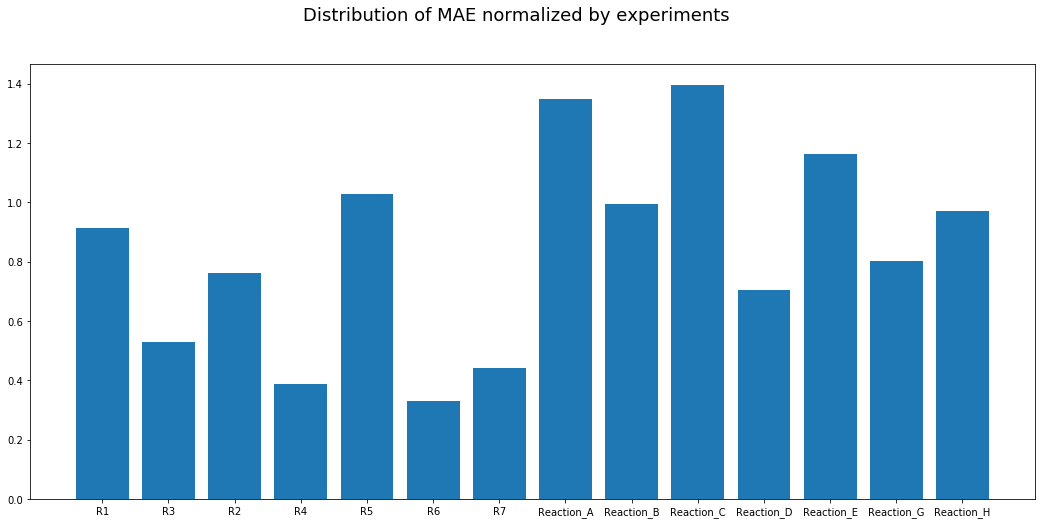

In [969]:
plt.figure(figsize=(18,8))

plt.bar(range(len(stat_dic)), stat_dic.values(), align='center')
plt.xticks(range(len(stat_dic)), stat_dic.keys())
plt.suptitle("Distribution of MAE normalized by experiments", fontsize=18)
plt.show()



|            | Average testing mean absolute error normalized | 
| ------------- | ------------- 
| ro_sphere  | 0.22
| sigma_sphere |  1.19 
|g_precursor | 0.57  | 
| rg_precursor | 0.84 |